<a href="https://colab.research.google.com/github/liewweiyuan/cs4375fyp/blob/main/cs4375fyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a project that takes this given dataset:

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

process it, and turns it into a FFNN-based credit card fraud detector

Firstly, we have to start by visualize and process the data.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import random

HIDDEN = 16
EPOCHS = 10

class FFNN(nn.Module):
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU() # The rectified linear unit; one valid choice of activation function
        self.output_dim = 2 # Either transaction is fraud or not a fraud
        self.W2 = nn.Linear(h, self.output_dim)

        self.softmax = nn.LogSoftmax() # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
        self.loss = nn.NLLLoss() # The cross-entropy/negative log likelihood loss taught in class

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector):
        # [to fill] obtain first hidden layer representation
        hidden = self.activation(self.W1(input_vector))

        # [to fill] obtain output layer representation
        output = self.W2(hidden)

        # [to fill] obtain probability dist.
        predicted_vector = self.softmax(output)

        return predicted_vector

def load_data():
  URL_='creditcard.csv'
  data = pd.read_csv(URL_)
  return data

df = load_data()
df.shape

(284807, 31)

In [ ]:
df.head() # lets us see what values of each column means

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.isnull().sum().max() # checks if dataset has any null values

0

In [ ]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

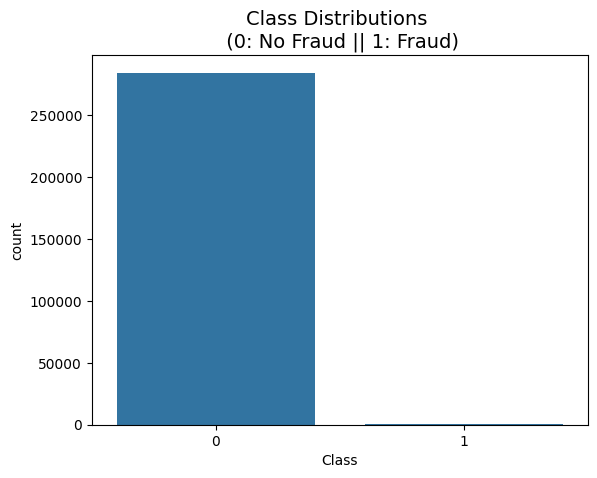

In [ ]:
sns.countplot(data=df, x='Class')
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

As we can see, there are 284807 data entries, each having 31 features. We do not know what most features due to confidentiality issues. The only thing we know for each transaction is time, amount and class. Another thing worth noting about this dataset is that it has a heavily skewed class distribution, where only 492 cases are deemed as fraud incidents, and the other 284315 are just regular transactions.

Let us see what happens if we build the model in a straightforward fashion without any data preprocessing, which means ignoring the heavily imbalanced classification and the scaling of time and amount feature that was left unaffected by the PCA transformation, and possible outliers of the features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# split data into training(60%), validation(20%), and test(20%) set
x_features = torch.tensor(df.drop(['Time','Class'], axis = 1).values.astype(np.float32))
y_target = torch.tensor(df['Class'].values.astype(np.int64))
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=42, stratify=y_target)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2

In [ ]:
# train the model
model = FFNN(input_dim = x_train.shape[1], h = HIDDEN)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
print("========== Training for {} epochs ==========".format(EPOCHS))
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    print("Training started for epoch {}".format(epoch + 1))
    x_train, y_train = shuffle(x_train, y_train, random_state=42) # Good practice to shuffle order of training data
    minibatch_size = 16
    N = len(x_train)
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector= x_train[minibatch_index * minibatch_size + example_index]
            gold_label =  y_train[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    print("Training completed for epoch {}".format(epoch + 1))
    print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    print("Training time for this epoch: {}".format(time.time() - start_time))


    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    print("Validation started for epoch {}".format(epoch + 1))
    minibatch_size = 16
    N = len(x_val)
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector = x_val[minibatch_index * minibatch_size + example_index]
            gold_label = y_val[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
    print("Validation completed for epoch {}".format(epoch + 1))
    print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    print("Validation time for this epoch: {}".format(time.time() - start_time))

========== Training for 10 epochs ==========
Training started for epoch 1


  0%|          | 0/10680 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 10680/10680 [01:12<00:00, 146.96it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.9985838014981273
Training time for this epoch: 72.75037884712219
Validation started for epoch 1


100%|██████████| 3560/3560 [00:13<00:00, 260.91it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.9987886235955056
Validation time for this epoch: 13.655932903289795
Training started for epoch 2


100%|██████████| 10680/10680 [01:15<00:00, 140.66it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.998817883895131
Training time for this epoch: 75.9860770702362
Validation started for epoch 2


100%|██████████| 3560/3560 [00:13<00:00, 258.26it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.9986657303370786
Validation time for this epoch: 13.792388439178467
Training started for epoch 3


100%|██████████| 10680/10680 [01:11<00:00, 148.46it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.9988295880149812
Training time for this epoch: 71.99881386756897
Validation started for epoch 3


100%|██████████| 3560/3560 [00:13<00:00, 261.94it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.9986481741573033
Validation time for this epoch: 13.60090970993042
Training started for epoch 4


100%|██████████| 10680/10680 [01:14<00:00, 142.59it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.9988647003745318
Training time for this epoch: 74.94315195083618
Validation started for epoch 4


100%|██████████| 3560/3560 [00:15<00:00, 226.61it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.9986657303370786
Validation time for this epoch: 15.716783285140991
Training started for epoch 5


100%|██████████| 10680/10680 [01:13<00:00, 144.82it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.9988412921348314
Training time for this epoch: 73.78771924972534
Validation started for epoch 5


100%|██████████| 3560/3560 [00:13<00:00, 260.84it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.9987183988764045
Validation time for this epoch: 13.656774520874023
Training started for epoch 6


100%|██████████| 10680/10680 [01:17<00:00, 138.17it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.9988705524344569
Training time for this epoch: 77.34238338470459
Validation started for epoch 6


100%|██████████| 3560/3560 [00:13<00:00, 258.13it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.9986481741573033
Validation time for this epoch: 13.7980318069458
Training started for epoch 7


100%|██████████| 10680/10680 [01:15<00:00, 142.10it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.9988529962546816
Training time for this epoch: 75.20129919052124
Validation started for epoch 7


100%|██████████| 3560/3560 [00:13<00:00, 254.31it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.9986832865168539
Validation time for this epoch: 14.009388446807861
Training started for epoch 8


100%|██████████| 10680/10680 [01:15<00:00, 141.29it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.9988881086142322
Training time for this epoch: 75.63235521316528
Validation started for epoch 8


100%|██████████| 3560/3560 [00:13<00:00, 264.84it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.9987183988764045
Validation time for this epoch: 13.450640201568604
Training started for epoch 9


100%|██████████| 10680/10680 [01:14<00:00, 142.98it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.9988705524344569
Training time for this epoch: 74.73589634895325
Validation started for epoch 9


100%|██████████| 3560/3560 [00:13<00:00, 261.42it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.9986306179775281
Validation time for this epoch: 13.628422260284424
Training started for epoch 10


100%|██████████| 10680/10680 [01:13<00:00, 144.79it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.9988939606741573
Training time for this epoch: 73.80572772026062
Validation started for epoch 10


100%|██████████| 3560/3560 [00:15<00:00, 223.14it/s]

Validation completed for epoch 10
Validation accuracy for epoch 10: 0.9988237359550561
Validation time for this epoch: 15.967089653015137


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


all_predictions = []
all_labels = []

loss = None
correct = 0
total = 0
start_time = time.time()
print("========== Accuracy test on the model ==========")
minibatch_size = 16
N = len(x_test)
for minibatch_index in tqdm(range(N // minibatch_size)):
    optimizer.zero_grad()
    loss = None
    for example_index in range(minibatch_size):
        input_vector = x_test[minibatch_index * minibatch_size + example_index]
        gold_label = y_test[minibatch_index * minibatch_size + example_index]
        predicted_vector = model(input_vector)
        predicted_label = torch.argmax(predicted_vector)
        correct += int(predicted_label == gold_label)
        total += 1
        example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
        if loss is None:
            loss = example_loss
        else:
            loss += example_loss

        all_predictions.append(predicted_label)
        all_labels.append(gold_label)
    loss = loss / minibatch_size
print("Accuracy test finished.")
print("Accuracy: {}".format(correct / total))

========== Accuracy test on the model ==========


  0%|          | 0/3560 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 3560/3560 [00:17<00:00, 205.33it/s]

Accuracy test finished.
Accuracy: 0.9988412921348314


In [ ]:
# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_predictions)  # For binary classification

# Plot confusion matrix
print(conf_matrix)

# Display metrics
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

[[56853     9]
 [   57    41]]
Accuracy: 0.9988, Precision: 0.8200, Recall: 0.4184, F1: 0.5541, AUC: 0.7091


As we can see, the accuracy of the model is suspiciously high, even though the dataset has such little fraud cases. From the confusion matrix, we can also see that is not predicting fraud cases as accurately as it should. Is the model correctly predicting the fraud cases, or is the model accuracy coming from the many cases of normal transactions? Let's find out by have the model only run a test on the fraud cases.

In [ ]:
x_target = x_features[y_target == 1]

loss = None
correct = 0
total = 0
start_time = time.time()
print("========== Accuracy test on ONLY fraud cases ==========")
minibatch_size = 16
N = len(x_target)
for minibatch_index in tqdm(range(N // minibatch_size)):
    optimizer.zero_grad()
    loss = None
    for example_index in range(minibatch_size):
        input_vector = x_target[minibatch_index * minibatch_size + example_index]
        gold_label = 1
        predicted_vector = model(input_vector)
        predicted_label = torch.argmax(predicted_vector)
        correct += int(predicted_label == gold_label)
        total += 1
        example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
        if loss is None:
            loss = example_loss
        else:
            loss += example_loss
    loss = loss / minibatch_size
print("Accuracy test finished.")
print("Accuracy: {}".format(correct / total))

========== Accuracy test on ONLY fraud cases ==========


  0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 30/30 [00:00<00:00, 136.56it/s]

Accuracy test finished.
Accuracy: 0.46875


As we can see, when running the model with only fraud cases, it is only able to get it right 30% of the time. Thus, this data imbalance has to be dealt with for us to get accurate results. Let us redo the model, starting with data preprocessing.

There are 4 steps to this process.

1. Scale the data
2. Split the data into training, validation and test sets
3. SMOTE
4. Random undersampling

#**Scaling the data**
Why do we scale the data? This is to ensure value uniformity across features such that no one feature affects the outcome more due to it having skewed values.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_features = sc.fit_transform(x_features)

x_features[0]

array([-0.69424232, -0.04407493,  1.67277346,  0.97336552, -0.24511658,
        0.34706794,  0.19367894,  0.08263728,  0.33112778,  0.08338554,
       -0.54040706, -0.61829569, -0.99609895, -0.32461019,  1.60401383,
       -0.53683285,  0.24486346,  0.03076993,  0.49628202,  0.32611801,
       -0.02492337,  0.38285444, -0.17691133,  0.11050692,  0.24658543,
       -0.39217042,  0.33089163, -0.06378115,  0.24496424])

# **Splitting the data**

In [ ]:
# split data into training(60%), validation(20%), and test(20%) set
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2, random_state=42, stratify=y_target)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)  # 0.25 x 0.8 = 0.2

# **SMOTE**
SMOTE, acronym for Synthetic Minority Oversampling Technique, is the first part in making an imbalanced dataset usable. SMOTE works by synthesize new examples from the minory class. It starts by selecting examples that are close in the feature space, and look for nearest neighbors as synthetic example candidates.

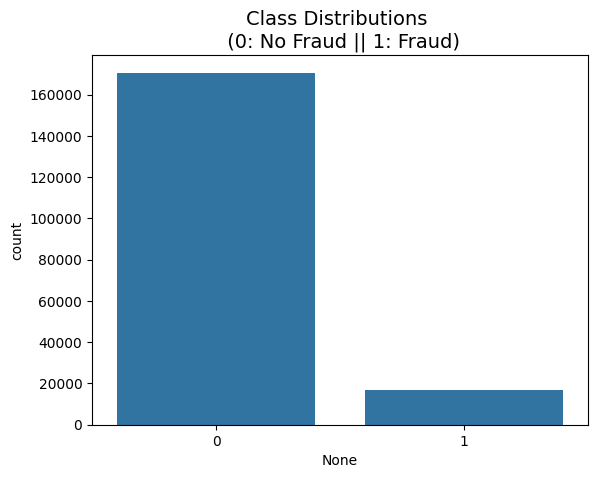

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.1, random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

sns.countplot(x=pd.Series(y_train_resampled))
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

# **Random undersampling**
This is the second part to make an imbalanced dataset usable. Random undersampling works by sampling a lesser amount of the majority class in order to balance out the class distribution. Normally, this can be used on its on, but together with SMOTE, the data comes out more refined with less loss in information.

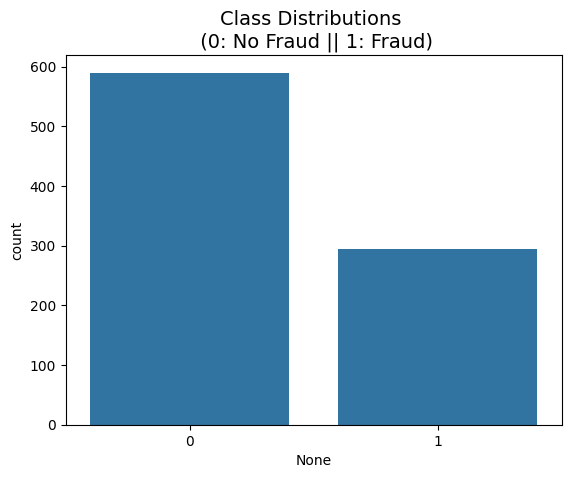

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
x_train_resampled, y_train_resampled = under.fit_resample(x_train, y_train)

sns.countplot(x=pd.Series(y_train_resampled))
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

After all the data preprocessing, let's try and retrain the model.

In [ ]:
# train the model
model = FFNN(input_dim = x_train_resampled.shape[1], h = HIDDEN)
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
print("========== Training for {} epochs ==========".format(EPOCHS))
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    print("Training started for epoch {}".format(epoch + 1))
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=42) # Good practice to shuffle order of training data
    minibatch_size = 16
    N = len(x_train_resampled)
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector= x_train_resampled[minibatch_index * minibatch_size + example_index]
            gold_label =  y_train_resampled[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(torch.tensor(input_vector.astype(np.float32)))
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
        loss.backward()
        optimizer.step()
    print("Training completed for epoch {}".format(epoch + 1))
    print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    print("Training time for this epoch: {}".format(time.time() - start_time))


    loss = None
    correct = 0
    total = 0
    start_time = time.time()
    print("Validation started for epoch {}".format(epoch + 1))
    minibatch_size = 16
    N = len(x_val)
    for minibatch_index in tqdm(range(N // minibatch_size)):
        optimizer.zero_grad()
        loss = None
        for example_index in range(minibatch_size):
            input_vector = x_val[minibatch_index * minibatch_size + example_index]
            gold_label = y_val[minibatch_index * minibatch_size + example_index]
            predicted_vector = model(torch.tensor(input_vector.astype(np.float32)))
            predicted_label = torch.argmax(predicted_vector)
            correct += int(predicted_label == gold_label)
            total += 1
            example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
            if loss is None:
                loss = example_loss
            else:
                loss += example_loss
        loss = loss / minibatch_size
    print("Validation completed for epoch {}".format(epoch + 1))
    print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
    print("Validation time for this epoch: {}".format(time.time() - start_time))

========== Training for 10 epochs ==========
Training started for epoch 1


100%|██████████| 55/55 [00:00<00:00, 95.82it/s]


Training completed for epoch 1
Training accuracy for epoch 1: 0.9068181818181819
Training time for this epoch: 0.5905234813690186
Validation started for epoch 1


100%|██████████| 3560/3560 [00:20<00:00, 174.51it/s]


Validation completed for epoch 1
Validation accuracy for epoch 1: 0.9948735955056179
Validation time for this epoch: 20.413835048675537
Training started for epoch 2


100%|██████████| 55/55 [00:00<00:00, 65.18it/s]


Training completed for epoch 2
Training accuracy for epoch 2: 0.9534090909090909
Training time for this epoch: 0.8683526515960693
Validation started for epoch 2


100%|██████████| 3560/3560 [00:17<00:00, 205.71it/s]


Validation completed for epoch 2
Validation accuracy for epoch 2: 0.9888869382022472
Validation time for this epoch: 17.31487488746643
Training started for epoch 3


100%|██████████| 55/55 [00:00<00:00, 147.96it/s]


Training completed for epoch 3
Training accuracy for epoch 3: 0.9579545454545455
Training time for this epoch: 0.3800690174102783
Validation started for epoch 3


100%|██████████| 3560/3560 [00:16<00:00, 215.51it/s]


Validation completed for epoch 3
Validation accuracy for epoch 3: 0.9846558988764045
Validation time for this epoch: 16.528299570083618
Training started for epoch 4


100%|██████████| 55/55 [00:00<00:00, 139.12it/s]


Training completed for epoch 4
Training accuracy for epoch 4: 0.9636363636363636
Training time for this epoch: 0.4072999954223633
Validation started for epoch 4


100%|██████████| 3560/3560 [00:17<00:00, 203.41it/s]


Validation completed for epoch 4
Validation accuracy for epoch 4: 0.9875702247191012
Validation time for this epoch: 17.51264715194702
Training started for epoch 5


100%|██████████| 55/55 [00:00<00:00, 90.12it/s]


Training completed for epoch 5
Training accuracy for epoch 5: 0.9647727272727272
Training time for this epoch: 0.6220624446868896
Validation started for epoch 5


100%|██████████| 3560/3560 [00:16<00:00, 215.29it/s]


Validation completed for epoch 5
Validation accuracy for epoch 5: 0.984375
Validation time for this epoch: 16.542237758636475
Training started for epoch 6


100%|██████████| 55/55 [00:00<00:00, 138.37it/s]


Training completed for epoch 6
Training accuracy for epoch 6: 0.9670454545454545
Training time for this epoch: 0.4084591865539551
Validation started for epoch 6


100%|██████████| 3560/3560 [00:18<00:00, 191.74it/s]


Validation completed for epoch 6
Validation accuracy for epoch 6: 0.9823033707865169
Validation time for this epoch: 18.57511806488037
Training started for epoch 7


100%|██████████| 55/55 [00:00<00:00, 148.48it/s]


Training completed for epoch 7
Training accuracy for epoch 7: 0.9659090909090909
Training time for this epoch: 0.3833351135253906
Validation started for epoch 7


100%|██████████| 3560/3560 [00:16<00:00, 218.71it/s]


Validation completed for epoch 7
Validation accuracy for epoch 7: 0.9829880617977528
Validation time for this epoch: 16.283143758773804
Training started for epoch 8


100%|██████████| 55/55 [00:00<00:00, 151.16it/s]


Training completed for epoch 8
Training accuracy for epoch 8: 0.9681818181818181
Training time for this epoch: 0.3749575614929199
Validation started for epoch 8


100%|██████████| 3560/3560 [00:16<00:00, 214.65it/s]


Validation completed for epoch 8
Validation accuracy for epoch 8: 0.9859550561797753
Validation time for this epoch: 16.594195127487183
Training started for epoch 9


100%|██████████| 55/55 [00:00<00:00, 143.72it/s]


Training completed for epoch 9
Training accuracy for epoch 9: 0.9681818181818181
Training time for this epoch: 0.39212989807128906
Validation started for epoch 9


100%|██████████| 3560/3560 [00:18<00:00, 196.18it/s]


Validation completed for epoch 9
Validation accuracy for epoch 9: 0.9831460674157303
Validation time for this epoch: 18.154494524002075
Training started for epoch 10


100%|██████████| 55/55 [00:00<00:00, 81.80it/s]


Training completed for epoch 10
Training accuracy for epoch 10: 0.9727272727272728
Training time for this epoch: 0.684072732925415
Validation started for epoch 10


100%|██████████| 3560/3560 [00:17<00:00, 208.01it/s]

Validation completed for epoch 10
Validation accuracy for epoch 10: 0.9796523876404495
Validation time for this epoch: 17.124439001083374


In [ ]:
all_predictions = []
all_labels = []

loss = None
correct = 0
total = 0
start_time = time.time()
print("========== Accuracy test on the model ==========")
minibatch_size = 16
N = len(x_test)
for minibatch_index in tqdm(range(N // minibatch_size)):
    optimizer.zero_grad()
    loss = None
    for example_index in range(minibatch_size):
        input_vector = x_test[minibatch_index * minibatch_size + example_index]
        gold_label = y_test[minibatch_index * minibatch_size + example_index]
        predicted_vector = model(torch.tensor(input_vector.astype(np.float32)))
        predicted_label = torch.argmax(predicted_vector)
        correct += int(predicted_label == gold_label)
        total += 1
        example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
        if loss is None:
            loss = example_loss
        else:
            loss += example_loss
        all_predictions.append(predicted_label)
        all_labels.append(gold_label)
    loss = loss / minibatch_size
print("Accuracy test finished.")
print("Accuracy: {}".format(correct / total))

========== Accuracy test on the model ==========


100%|██████████| 3560/3560 [00:16<00:00, 214.24it/s]

Accuracy test finished.
Accuracy: 0.9793890449438202


In [ ]:
# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_predictions)  # For binary classification

# Plot confusion matrix
print(conf_matrix)

# Display metrics
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

[[55697  1165]
 [    9    89]]
Accuracy: 0.9794, Precision: 0.0710, Recall: 0.9082, F1: 0.1317, AUC: 0.9438


In [ ]:
loss = None
correct = 0
total = 0
start_time = time.time()
print("========== Accuracy test on ONLY fraud cases ==========")
minibatch_size = 16
N = len(x_target)
for minibatch_index in tqdm(range(N // minibatch_size)):
    optimizer.zero_grad()
    loss = None
    for example_index in range(minibatch_size):
        input_vector = x_target[minibatch_index * minibatch_size + example_index]
        gold_label = 1
        predicted_vector = model(input_vector)
        predicted_label = torch.argmax(predicted_vector)
        correct += int(predicted_label == gold_label)
        total += 1
        example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
        if loss is None:
            loss = example_loss
        else:
            loss += example_loss
    loss = loss / minibatch_size
print("Accuracy test finished.")
print("Accuracy: {}".format(correct / total))

========== Accuracy test on ONLY fraud cases ==========


100%|██████████| 30/30 [00:00<00:00, 290.05it/s]

Accuracy test finished.
Accuracy: 0.9645833333333333
